In [94]:
import pandas as pd
import numpy as np
import sklearn.preprocessing

In [95]:
raw_houses_df = pd.read_csv('../data/01_houses/train.csv').dropna(axis=1).fillna(0)
houses_df = raw_houses_df.filter(c for c in raw_houses_df.columns if raw_houses_df.dtypes[c] in [np.int64, np.float64])
houses_df = houses_df.drop([ 'BsmtHalfBath' , 'BsmtFullBath', 'Id', 'MSSubClass', 'MiscVal', 'BsmtUnfSF', '3SsnPorch', 'MiscVal', 'YrSold', "MoSold"], axis=1)

In [96]:
from sklearn.model_selection import train_test_split

y_cols = ['SalePrice']
X_cols = [c for c in houses_df.columns if c not in y_cols]

X, y = houses_df.filter(X_cols), houses_df.filter(y_cols)

X_train, X_test, y_train, y_test = train_test_split(X.astype(np.float32),y, test_size=0.2)

In [97]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


scaler = StandardScaler().fit( X)
regressor = DecisionTreeRegressor()
# clf = regressor.fit(scaler.transform(X_train), y_train/1000)

from sklearn.pipeline import Pipeline

pipeline = make_pipeline(scaler, regressor)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [98]:
import matplotlib.pyplot as plt
houses_df['PredictedSalePrice'] = pipeline.predict(X)

sorted_houses_df = houses_df.sort_values('SalePrice')[['SalePrice', 'PredictedSalePrice']]
plt.figure()
plt.plot(sorted_houses_df['PredictedSalePrice'].tolist(), alpha=0.5, c='red')
plt.plot(sorted_houses_df['SalePrice'].tolist(), alpha=0.9)
plt.legend(['Predicted Sale Price', 'Real Sale Price' ])
ax = plt.gca()
ax.get_xaxis().set_visible(False)

plt.figure()
sorted_houses_df = houses_df.sort_values('PredictedSalePrice')[['SalePrice', 'PredictedSalePrice']]
plt.plot(sorted_houses_df['SalePrice'].tolist(), alpha=0.5)
plt.plot(sorted_houses_df['PredictedSalePrice'].tolist(), alpha=1, c='red')

plt.legend(['Predicted Sale Price', 'Real Sale Price' ][::-1])
ax = plt.gca()
ax.get_xaxis().set_visible(False)
# plt.plot(sorted(houses_df[['SalePrice', 'PredictedSalePrice']].tolist()))

In [99]:
import shap

# explainer = shap.explainers.Tree(pipeline, X_train)
# svt = explainer(X_train)
explainer = shap.explainers.Permutation(pipeline.predict, X_train)
svp = explainer(X_train)
# explainer = shap.explainers.Sampling(clf.predict, X_train)
# svs = explainer(X_train)


Permutation explainer: 1169it [00:38, 22.70it/s]                          


In [100]:
# exp_t= shap.Explanation( svt.values, svt.base_values[0], (svt.data), feature_names=X_cols)
exp_p = shap.Explanation( svp.values, svp.base_values[0], (svp.data), feature_names=X_cols)
# exp_s = shap.Explanation( svs.values, svs.base_values, X_scaler.inverse_transform(svs.data), feature_names=X_cols)

In [101]:
shap.plots.waterfall(exp_p[1])

In [102]:
shap.plots.waterfall(exp_p[11])

In [103]:
shap.plots.beeswarm(exp_p) #waterfall(exp_t[10])

In [104]:
# pd.DataFrame(X_scaler.inverse_transform(X_train) ,columns=X_cols)[['OverallQual', 'GrLivArea', 'BsmtFinSF1', 'TotalBsmtSF', 'YearRemodAdd', 'YearBuilt']]

In [105]:
# corr = r_regression(X_train, y_train[:,0])
# shap_tree = np.mean(svt.values, 0)
shap_permutation = np.mean(svp.values, 0)
# shap_sampling = np.mean(svs.values, 0)

In [106]:
# df_pearson = pd.DataFrame([X_cols, ['Pearson']*len(X_cols), (corr).tolist(),  ], index=['feature', 'estimator', 'value'])
# df_shapt = pd.DataFrame([X_cols, ['SHAP - tree']*len(X_cols), (shap_tree).tolist(),  ], index=['feature', 'estimator', 'value'])
# df_shapp = pd.DataFrame([X_cols, ['SHAP - permute']*len(X_cols), (shap_permutation).tolist(),  ], index=['feature', 'estimator', 'value'])
# df_shaps = pd.DataFrame([X_cols, ['SHAP - sample']*len(X_cols), (shap_sampling).tolist(),  ], index=['feature', 'estimator', 'value'])

# df_pearson.loc['value'] = (df_pearson.loc['value'] ) / df_pearson.loc['value'].std() + 1
# df_shapt.loc['value'] = (df_shapt.loc['value'] ) / df_shapt.loc['value'].std() + 1
# df_shapp.loc['value'] = (df_shapp.loc['value'] ) / df_shapp.loc['value'].std() + 1
# df_shaps.loc['value'] = (df_shaps.loc['value'] ) / df_shaps.loc['value'].std() + 1

# df = pd.concat(( df_shapt, df_shapp, ), axis=1).T #df_shaps
# df

In [107]:
# import matplotlib.pyplot as plt 
# import seaborn as sns

# plt.figure(figsize=(20,20))
# sns.catplot(
#     data=df[(df["feature"] != '2ndFlrSF') & (df["feature"] != 'Id')], kind="bar",
#     y="feature", x="value", hue="estimator",
#      alpha=.6, height=20
# )

In [108]:
from minisom import MiniSom
import torch



data = np.hstack([X,y])

som = MiniSom(15, 15, data.shape[1], sigma=1.5, learning_rate=.7, activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian', random_seed=10)

som.train( sklearn.preprocessing.StandardScaler().fit_transform( data), 1000, verbose=True)
data.shape


 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 2.435056800834764


(1460, 26)

In [109]:
xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()
weights.shape

(15, 15, 26)

In [110]:
# import sklearn.decomposition
# import seaborn as sns

# def update(n_clusters, X_train):
#     pca = sklearn.decomposition.PCA(n_clusters)
#     xx, yy = pca.fit_transform(scaler.transform(X_train)).T
#     plot = sns.scatterplot(x=xx, y=yy, hue=y_train['SalePrice'])
#     return plot

# update(2, X_train)

In [111]:
import sklearn.cluster
import sklearn.decomposition



kmeans = sklearn.cluster.KMeans(20)
pca = sklearn.decomposition.PCA(10)

train_shap = pd.DataFrame(svp.values, columns=X_cols)

train_shap['Clusters'] = np.argmin(kmeans.fit_transform(svp.values), axis=1)

clust_train_shap = train_shap.groupby('Clusters').mean().astype('int')

pca_clust_train_shap = pca.fit_transform(clust_train_shap)
pca_clust_train_shap = pd.DataFrame(pca_clust_train_shap, index=[f'cluster {i}' for i in range(pca_clust_train_shap.shape[0])], columns=[f'feature {i}' for i in range(pca_clust_train_shap.shape[1])])


/Users/di3go/miniconda3/envs/xai-workbench/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [112]:
# def colormap(x):
#     return f"background-color: #%02x%02x%02x ; color: %s"  % tuple([int(c*255) for c in plt.cm.RdBu_r(x/30000+0.5)[:3]]+['black' if abs(x)<15000 else 'white'] )
# train_shap.style.applymap(colormap )


In [113]:
def colormap(x):
    return f"background-color: #%02x%02x%02x ; color: %s"  % tuple([int(c*255) for c in plt.cm.RdBu_r(x/30000+0.5)[:3]]+['black' if abs(x)<15000 else 'white'] )
clust_train_shap.style.applymap(colormap )


,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea
Clusters,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1179,-8792,932,-338,-1984,-2789,-130,-6767,-485,228,1,7888,169,204,985,-85,244,171,-1097,-232,1259,-34,469,-163,0
1,1481,113149,-58,3242,1104,3488,-80,6233,7441,-368,0,-2897,35,84,-293,0,179,888,7243,-4198,-646,139,200,92,0
2,512,21464,-251,-8047,2502,3417,-74,26973,1324,-1264,0,3576,140,-49,-157,0,941,49,19,999,711,202,201,304,0
3,335,9011,-9,3049,5497,-2061,-90,-5765,-548,-414,0,-3884,176,-85,99,0,37,395,-144,1037,1062,61,403,-5,0
4,-114,11291,-168,1753,6210,-415,-99,-3382,-133,678,0,25881,164,361,-724,2,758,266,461,724,1214,253,270,198,0
5,-1457,-34330,-610,-6718,-1568,-7229,-265,-738,-22,-18,79,10006,87,14,202,-750,227,355,-1747,-1162,1863,-1132,335,-93,0
6,-1149,-24464,553,-1210,-1216,5422,-42,-4672,-550,-94,0,-15502,-110,85,-27,0,411,203,-86,-760,1318,-148,518,88,0
7,2811,248191,179,838,140,8211,86,6789,27146,104549,0,167903,68,182,5906,0,-593,718,2004,573,485,0,83,-38,0
8,-9100,215632,-126,2482,928,2363,-39,11421,17808,1476,77,88918,66,46,6120,0,-414,800,2420,1674,24795,165,144,745,0


In [114]:

def colormap(x):
    return f"background-color: #%02x%02x%02x ; color: %s"  % tuple([int(c*255) for c in plt.cm.RdBu_r(x/30000+0.5)[:3]]+['black' if abs(x)<15000 else 'white'] )

s_clust_train_shap = clust_train_shap.reindex((-np.abs(clust_train_shap).sum()).sort_values(axis=0).index, axis=1)
s_clust_train_shap = s_clust_train_shap.reindex((-np.abs(clust_train_shap).sum(axis=1)).sort_values().index, axis=0)

s_clust_train_shap.style.applymap(colormap )


,OverallQual,GrLivArea,TotalBsmtSF,2ndFlrSF,BsmtFinSF1,1stFlrSF,WoodDeckSF,YearBuilt,LotArea,YearRemodAdd,GarageCars,GarageArea,BedroomAbvGr,TotRmsAbvGrd,OpenPorchSF,OverallCond,Fireplaces,EnclosedPorch,ScreenPorch,BsmtFinSF2,HalfBath,FullBath,KitchenAbvGr,LowQualFinSF,PoolArea
Clusters,,,,,,,,,,,,,,,,,,,,,,,,,
7,248191,167903,6789,104549,8211,27146,485,838,2811,140,2004,573,5906,-593,0,179,718,83,-38,86,182,68,0,0,0
8,215632,88918,11421,1476,2363,17808,24795,2482,-9100,928,2420,1674,6120,-414,165,-126,800,144,745,-39,46,66,0,77,0
9,180925,13698,15517,-1919,7956,41918,-19130,3577,3399,498,597,752,-4546,111,1688,-237,619,180,-8,-122,165,35,0,0,0
17,151018,69321,12007,5027,-364,-451,-33686,2405,2199,654,4051,77,1829,-460,-183,216,900,506,-6,-97,224,66,4,0,0
11,79051,30979,19405,415,26332,1012,3833,3175,1833,449,2890,4951,-118,-548,238,-260,403,184,-67,-277,-21,75,0,0,0
12,58036,69199,1827,5596,-3355,327,5955,2262,2505,580,5491,991,709,-3982,-1704,144,1072,200,108,-531,484,171,0,0,0
1,113149,-2897,6233,-368,3488,7441,-646,3242,1481,1104,7243,-4198,-293,179,139,-58,888,200,92,-80,84,35,0,0,0
10,53293,-16271,46469,-307,20748,1501,906,3286,-96,128,893,1039,-943,-2799,298,-91,223,238,558,65,-173,246,0,0,0
15,40078,-3531,33631,-554,-10779,2332,556,4642,-3115,1701,405,6596,-55,523,-525,127,-137,179,-19,-111,21,191,0,0,0


In [115]:
def colormap(x):
    return f"background-color: #%02x%02x%02x ; color: %s"  % tuple([int(c*255) for c in plt.cm.RdBu_r(x/60000+0.5)[:3]]+['black' if abs(x)<30000 else 'white'] )
pca_clust_train_shap.style.applymap(colormap )


,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9
cluster 0,-63961.315007,12863.947785,-5134.339820,-7207.146962,-1454.254613,-412.432012,-647.380503,224.573253,-1741.999298,-2760.244725
cluster 1,42753.689408,-48002.421369,-2205.868546,-14448.890897,-5811.235415,-759.614482,-11114.685403,-1799.353927,6876.225608,1043.980038
cluster 2,-36970.449425,-11177.698332,11760.251943,13871.843661,1297.277489,5366.890359,3192.709942,6704.584520,870.767406,5140.524265
cluster 3,-52607.488989,-3992.381345,-3232.876908,-11246.440714,-3095.556544,-232.850053,-5261.144984,-5886.874261,-1743.821869,2973.016581
cluster 4,-38370.333921,17961.119248,-8428.067144,30.950736,772.756269,-2060.305457,309.784198,-4086.422288,-3155.103019,4121.629887
cluster 5,-86034.069102,23542.962974,-2169.542751,-967.001408,385.331522,5399.884183,5389.110393,5055.670588,-1113.393599,-215.777228
cluster 6,-87068.775190,-406.418789,4661.693794,-10233.701349,-4122.530375,-6565.208575,-2580.263147,607.314407,-1986.737100,-1385.279733
cluster 7,250205.092208,73091.199413,30349.139514,-14192.183648,-3661.461057,1061.876183,-962.719025,54.366074,-154.720422,96.210092
cluster 8,172413.650115,-16177.807100,-29378.450538,12675.833647,-25346.221434,3924.468536,-92.776231,3206.582977,-1692.044767,-767.615528
cluster 9,113657.706466,-69184.251899,-1337.453903,-21534.589264,7911.940818,-3445.988270,17459.927877,-1075.687606,-735.166635,-1.057204


In [116]:
columns_mapping = {
'LotArea': '🏞',
'OverallQual': '✨',
'OverallCond': '👍',
'YearBuilt': '📅',
'YearRemodAdd': '🧱',
'BsmtFinSF1': '🔽',
'BsmtFinSF2': '⏬',
'TotalBsmtSF': '⬇️',
'1stFlrSF': '1️⃣',
'2ndFlrSF': '2️⃣',
'LowQualFinSF': '',
'GrLivArea': '🌳',
'FullBath': '🛀',
'HalfBath': '🚽',
'BedroomAbvGr': '🛏',
'KitchenAbvGr': '🔪',
'TotRmsAbvGrd': '🔢',
'Fireplaces': '🔥',
'GarageCars': '🏎',
'GarageArea': '🚗',
'WoodDeckSF': '',
'OpenPorchSF': '⛩',
'EnclosedPorch': '🪟',
'ScreenPorch': '🪟',
'PoolArea': '🏊',
}



new_cols = []
for component in pca.components_:
    sorting_index = np.argsort(-np.abs(component), axis=0)
    top_indexes = [sorting_index[i]  for i in range(3)]
    top_cols =[X_cols[i]  for i in top_indexes ]
    top_values =[component[i]  for i in top_indexes ]
    # print(component.shape)
    # top_cols_repr = '\n'.join([columns_mapping.get(v)+v for v in top_cols])
    top_cols_repr = [columns_mapping.get(c, '')+f' {c} {v:.2f}' for i,c,v in zip(top_indexes, top_cols, top_values)]

    new_cols.append(top_cols_repr)


def colormap(x):
    return f"background-color: #%02x%02x%02x ; color: %s"  % tuple([int(c*255) for c in plt.cm.RdBu_r(x/60000+0.5)[:3]]+['black' if abs(x)<30000 else 'white'] )

pca_clust_train_shap.columns = pd.MultiIndex.from_arrays(np.transpose(new_cols))
pca_clust_train_shap_tmp = pca_clust_train_shap.copy()
pca_clust_train_shap_tmp['Price'] = y_train

# train_shap = train_shap['']
pca_clust_train_shap_tmp.style.applymap(colormap )


,✨ OverallQual 0.90,🌳 GrLivArea 0.78,2️⃣ 2ndFlrSF 0.77,⬇️ TotalBsmtSF 0.73,WoodDeckSF -0.94,🔽 BsmtFinSF1 -0.91,1️⃣ 1stFlrSF 0.89,📅 YearBuilt -0.83,🏞 LotArea 0.73,🧱 YearRemodAdd 0.84,Price
,🌳 GrLivArea 0.40,2️⃣ 2ndFlrSF 0.41,⬇️ TotalBsmtSF 0.50,2️⃣ 2ndFlrSF -0.38,🏞 LotArea 0.19,⬇️ TotalBsmtSF 0.31,2️⃣ 2ndFlrSF -0.19,🧱 YearRemodAdd -0.35,🏎 GarageCars 0.40,📅 YearBuilt -0.42,
,2️⃣ 2ndFlrSF 0.16,✨ OverallQual -0.39,🔽 BsmtFinSF1 0.26,🌳 GrLivArea 0.34,🌳 GrLivArea 0.14,🏞 LotArea -0.20,⬇️ TotalBsmtSF 0.19,🚗 GarageArea -0.26,🚗 GarageArea -0.38,🔢 TotRmsAbvGrd 0.19,
cluster 0,-63961.315007,12863.947785,-5134.339820,-7207.146962,-1454.254613,-412.432012,-647.380503,224.573253,-1741.999298,-2760.244725,nan
cluster 1,42753.689408,-48002.421369,-2205.868546,-14448.890897,-5811.235415,-759.614482,-11114.685403,-1799.353927,6876.225608,1043.980038,nan
cluster 2,-36970.449425,-11177.698332,11760.251943,13871.843661,1297.277489,5366.890359,3192.709942,6704.584520,870.767406,5140.524265,nan
cluster 3,-52607.488989,-3992.381345,-3232.876908,-11246.440714,-3095.556544,-232.850053,-5261.144984,-5886.874261,-1743.821869,2973.016581,nan
cluster 4,-38370.333921,17961.119248,-8428.067144,30.950736,772.756269,-2060.305457,309.784198,-4086.422288,-3155.103019,4121.629887,nan
cluster 5,-86034.069102,23542.962974,-2169.542751,-967.001408,385.331522,5399.884183,5389.110393,5055.670588,-1113.393599,-215.777228,nan
cluster 6,-87068.775190,-406.418789,4661.693794,-10233.701349,-4122.530375,-6565.208575,-2580.263147,607.314407,-1986.737100,-1385.279733,nan
cluster 7,250205.092208,73091.199413,30349.139514,-14192.183648,-3661.461057,1061.876183,-962.719025,54.366074,-154.720422,96.210092,nan


Default backend: module://mplcairo.macosx
Backend is now module://mplcairo.macosx


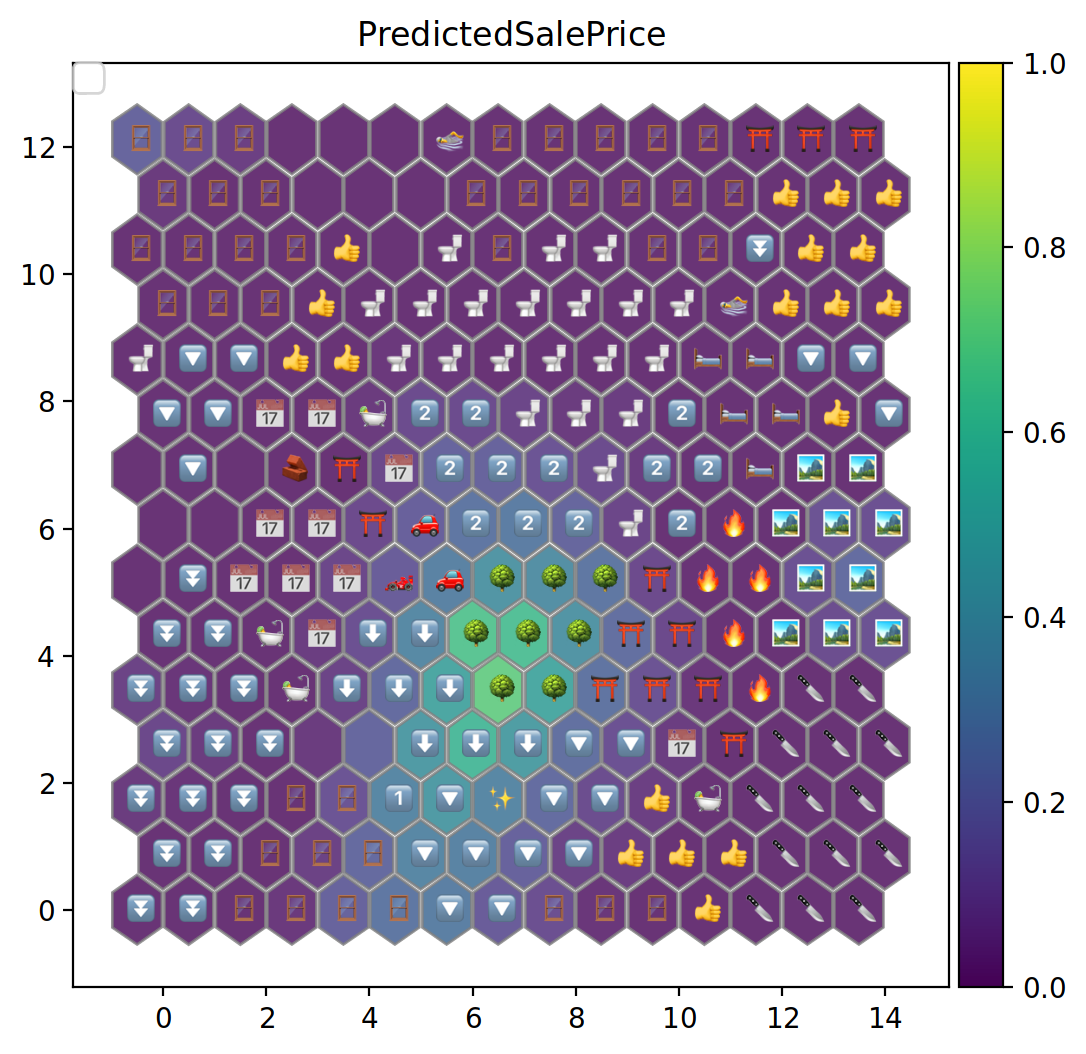

In [117]:
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

import matplotlib, mplcairo
print('Default backend: ' + matplotlib.get_backend()) 
matplotlib.use("module://mplcairo.macosx")
print('Backend is now ' + matplotlib.get_backend())

from matplotlib.font_manager import FontProperties
prop = FontProperties(fname='/System/Library/Fonts/Apple Color Emoji.ttc')


def plot_feature(feature_id):
        f = plt.figure(figsize=(6,6))
        ax = plt.gca()
        plt.ioff()

        for i in range(weights.shape[0]):
                for j in range(weights.shape[1]):
                        wy = yy[(i, j)] * np.sqrt(3) / 2
                        hex = RegularPolygon((xx[(i, j)], wy), 
                                        numVertices=6, 
                                        radius=.95 / np.sqrt(3),
                                        facecolor=cm.viridis( weights[i, j, feature_id] / (weights[:,:,feature_id].max() - weights[:,:,feature_id].min())), 
                                        alpha=.8, 
                                        
                                        edgecolor='gray')
                        ax.add_patch(hex)
                        top_col = np.argmax(weights[i,j,:-1], axis=0)
                        col_name =  columns_mapping.get( X_cols[top_col], '')
                        # print(col_weights)
                        ax.text(xx[(i, j)]-0.2, wy-0.2,col_name,fontproperties=prop,)

        # markers = ['o', '+', 'x']
        for cnt, x in enumerate(data):
                w = som.winner(x)

                wx, wy = som.convert_map_to_euclidean(w) 
                wy = wy * np.sqrt(3) / 2
                plt.plot(
                        #  markers[t[cnt]-1], 
                        markerfacecolor='None',
                        markersize=12, 
                        markeredgewidth=2)
                # plt.text(wx, wy, ' a')

        xrange = np.arange(weights.shape[0])
        yrange = np.arange(weights.shape[1])


        divider = make_axes_locatable(plt.gca())
        ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
        cb1 = colorbar.ColorbarBase(ax_cb, cmap='viridis', 
                                orientation='vertical', alpha=.4)

        plt.gcf().add_axes(ax_cb)

        legend_elements = []
        ax.legend(handles=legend_elements, loc='upper left', 
                borderaxespad=0., ncol=3, fontsize=14)

        ax.set_title(houses_df.columns[feature_id])
        return f
plot_feature(-1)

### Counterfactuals

In [119]:
import dice_ml
from dice_ml import Dice

d_iris = dice_ml.Data(dataframe=pd.DataFrame(data, columns=X_cols + y_cols),
                      continuous_features=X_cols,
                      outcome_name="SalePrice")


m_iris = dice_ml.Model(model=pipeline, backend="sklearn", model_type='regressor')
exp_genetic_iris = Dice(d_iris, m_iris, method="genetic")


In [120]:
query_instances_iris = X_test[2:3]
genetic_iris = exp_genetic_iris.generate_counterfactuals(query_instances_iris, total_CFs=15, desired_range=[150000,160000])
genetic_iris.visualize_as_dataframe()

100%|██████████| 1/1 [00:03<00:00,  3.30s/it]

Query instance (original outcome : 152000)


,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,SalePrice
0,10304,5,7,1976,1976,381,0,780,1088,780,...,9,1,2,484,448,96,0,0,0,152000.0



Diverse Counterfactual set (new outcome: [150000, 160000])


,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,PoolArea,SalePrice
0,10304.0,5.0,7.0,1976.0,1976.0,381.0,0.0,780.0,1088.0,780.0,...,9.0,1.0,2.0,484.0,448.0,96.0,0.0,0.0,0.0,152000.0
0,2308.0,6.0,6.0,1976.0,1976.0,556.0,0.0,804.0,804.0,744.0,...,7.0,1.0,2.0,440.0,48.0,0.0,0.0,0.0,0.0,159000.0
0,2280.0,6.0,6.0,1976.0,1976.0,566.0,0.0,855.0,855.0,601.0,...,7.0,1.0,2.0,440.0,87.0,0.0,0.0,0.0,0.0,159000.0
0,10793.0,5.0,5.0,1969.0,1969.0,493.0,287.0,780.0,780.0,840.0,...,7.0,0.0,2.0,462.0,208.0,0.0,0.0,0.0,0.0,152000.0
0,7931.0,6.0,6.0,1872.0,1976.0,566.0,0.0,0.0,1269.0,601.0,...,7.0,1.0,2.0,440.0,0.0,0.0,0.0,0.0,0.0,151000.0
0,11616.0,6.0,5.0,1978.0,1978.0,438.0,0.0,672.0,672.0,714.0,...,6.0,1.0,2.0,440.0,335.0,0.0,0.0,0.0,0.0,158900.0
0,17400.0,5.0,5.0,1977.0,1977.0,936.0,0.0,1126.0,1126.0,0.0,...,5.0,1.0,2.0,484.0,295.0,41.0,0.0,0.0,0.0,160000.0
0,10784.0,7.0,5.0,1991.0,1992.0,0.0,0.0,384.0,802.0,670.0,...,7.0,1.0,2.0,402.0,164.0,0.0,0.0,0.0,0.0,160000.0
0,3964.0,6.0,4.0,1973.0,1973.0,837.0,0.0,942.0,1291.0,1230.0,...,10.0,1.0,2.0,576.0,728.0,20.0,0.0,0.0,0.0,151400.0
0,11103.0,7.0,5.0,2006.0,2006.0,0.0,0.0,728.0,728.0,728.0,...,8.0,1.0,2.0,440.0,0.0,0.0,0.0,0.0,0.0,155835.0


### Explainer Dashboard

In [ ]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard
explainer = RegressionExplainer(pipeline, X_test, y_test)
ExplainerDashboard(explainer).run()
